In [ ]:
!pip install PyLDAVis
!pip install --upgrade pandas joblib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import pyLDAvis.lda_model
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
df = pd.read_csv('review_train.csv')
df1 = pd.read_csv('review_test.csv')

DATA PREPROCESSING


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stopwords
tfidf = TfidfVectorizer(stop_words='english')
tfidf1 = TfidfVectorizer(stop_words='english')

In [ ]:
tfidf_matrix = tfidf.fit_transform(df['Review'])
tfidf1_matrix = tfidf1.fit_transform(df1['Review'])

In [ ]:
# Import linear_kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim1 = linear_kernel(tfidf1_matrix, tfidf1_matrix)

In [ ]:
#Construct a reverse mapping of indices and movie titles, and drop duplicate titles, if any
indices = pd.Series(df.index, index=df['Restaurant']).drop_duplicates()
indices1 = pd.Series(df1.index, index=df1['Restaurant']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and gives recommendations
def content_recommender(title, cosine_sim=cosine_sim, df=df, indices=indices):
    # Obtain the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies. Ignore the first movie.
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(sim_scores)

    # Return the top 10 most similar movies
    return df['Restaurant'].iloc[movie_indices]

In [ ]:
#Get recommendations for The Lion King
content_recommender('Roi Spoon')

[(4611, 0.22931562357554616), (9604, 0.21806431066682508), (1674, 0.21285975321717426), (767, 0.21093702521563434), (2835, 0.19761115662136325), (4718, 0.1926298866178131), (8924, 0.19245440560689717), (6838, 0.19068177742109244), (9832, 0.1895273599880344), (9850, 0.18752746481586585)]


4611                   Nancy's Kitchen Restaurant
9604                      Nyonya Makko Restaurant
1674                         Village Briyani Cafe
767                        Restoran Absolute Thai
2835                                       Duddha
4718    Kampung Carabao Authentic Thai Restaurant
8924             Cottage Spices A Taste of Melaka
6838                               Positano Risto
9832                            KyoChon Pavillion
9850                                      Kim Joo
Name: Restaurant, dtype: object

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/saum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['Review'].apply(lambda x: sentiment_analyzer.polarity_scores(x))
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 'positive' if x['compound'] >= 0.1 else 'negative' if x['compound'] <= -0.1 else 'neutral')


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [ ]:
text = df['Review']
text = text.map(lambda text: text.lower())
text_all=text.values.tolist()
print(text[:3])

0    food test is nowhere near the hype, roasted ch...
1    nice place to visit everytime go melaka, not s...
2    i tried linguine bolognaise sauce... it's very...
Name: Review, dtype: object


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/saum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/saum/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer

tokens=[]
for sent in text:
    temp=[WordNetLemmatizer().lemmatize(word) for word in sent.split(" ")]
    tokens.append(temp)

In [ ]:
from sklearn.feature_extraction import text
stop_words = list(text.ENGLISH_STOP_WORDS)

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


NUM_TOPICS = 10

df['tokens']=tokens
text_train = list(df['tokens'].apply(lambda x: ' '.join(x)))

vectoriser = CountVectorizer(min_df=15, max_df=0.95,
                             stop_words=stop_words,lowercase=True,
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


data_vectorized = vectoriser.fit_transform(text_train)
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, random_state=258, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)

CPU times: user 13.7 s, sys: 67.8 ms, total: 13.8 s
Wall time: 13.8 s


In [ ]:
print(lda_Z.shape)

(10074, 10)


In [ ]:
def print_topics(model, vectoriser, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx+1))
        print([(vectoriser.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

print("LDA Model:")
print_topics(lda_model, vectoriser)
print("=" * 50)

LDA Model:
Topic 1:
[('chicken', 1264.9906747714354), ('rice', 1125.8932046835457), ('fried', 837.2042851412957), ('fish', 758.5656147120139), ('soup', 742.3029030615911), ('noodle', 414.3768518320012), ('dish', 329.6911912402584), ('duck', 323.80749161949484), ('ordered', 277.3251040014728), ('laksa', 262.04708473877326)]
Topic 2:
[('taste', 623.1128205523355), ('dish', 478.8862476419164), ('good', 474.82720116610824), ('food', 447.74353535443134), ('pork', 431.91721209418637), ('meat', 423.75540334424636), ('sauce', 367.4649864175448), ('like', 353.31275058473403), ('spicy', 317.3603797130268), ('beef', 290.4832350353902)]
Topic 3:
[('like', 926.7418976906266), ('food', 754.9788565051863), ('menu', 675.3746176705666), ('just', 585.3498383532936), ('really', 570.3554888958244), ('place', 520.3100697821881), ('restaurant', 442.76698001424353), ('bad', 395.68240310761183), ('ordered', 375.6121590648908), ('don', 367.7760792296217)]
Topic 4:
[('steak', 596.9663995064677), ('beer', 478.14

In [ ]:
x = lda_model.transform(data_vectorized)

In [ ]:
topics=pd.DataFrame(x)
topics.columns=['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10']

topics['Review']=df['Review']
topics['Restaurant']=df['Restaurant']
topics['Category']=df['Category']
pd.DataFrame(topics).to_csv('tweets_by_topics_all_new.csv',index=False)

In [ ]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.lda_model.prepare(lda_model, data_vectorized, vectoriser, mds='tsne', sort_topics = False)
panel

/Users/saum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/saum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/saum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/saum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/saum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires ver

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -52.087444 -27.350983       1        1   5.453199
1       5.783305  63.898560       2        1   6.710080
2      76.595718  -7.866434       3        1  14.716908
3      52.291824 -63.792191       4        1   4.077287
4     -10.720681  -8.288973       5        1  10.911004
5      23.225485  20.894642       6        1  11.627146
6      63.415321  43.912266       7        1  10.797654
7      -4.991211 -59.883724       8        1  15.210350
8     -36.731285  31.581278       9        1  11.474172
9      31.561188 -23.179960      10        1   9.022199, topic_info=         Term         Freq        Total Category  logprob  loglift
416   chicken  1930.000000  1930.000000  Default  30.0000  30.0000
1961     rice  1149.000000  1149.000000  Default  29.0000  29.0000
919      food  9475.000000  9475.000000  Default  28.0000  28.0000
2344    table  2104.000000  2104.000000  Default  27.0000  27.0000
1001     good  5278.000000  5278.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2417     time   258.674430  2599.466801  Topic10  -4.7723   0.0980
2031    sauce   190.373610   721.298430  Topic10  -5.0789   1.0734
485      come   201.904116  1273.358632  Topic10  -5.0201   0.5639
677    dinner   194.980144  1446.784253  Topic10  -5.0550   0.4013
1323     like   199.447301  2189.031456  Topic10  -5.0323   0.0098

[670 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         3  0.831534           able
2         8  0.166307           able
11        9  0.982079  accommodating
19        3  0.990880         actual
39        1  0.041930      afternoon
...     ...       ...            ...
2676      6  0.002081           year
2676      8  0.022896           year
2676      9  0.341365           year
2676     10  0.218557           year
2686      5  0.991647           zero

[1417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

RUNNING THE LSTM MODEL


In [ ]:
train = df.copy()
test = df1.copy()

In [ ]:
train['Rating'] = train['Rating'].str.split().str[0]
train['Rating'] = train['Rating'].astype(int)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

#split the dataset
x_train, x_test, y_train, y_test = train_test_split(train['Review'], train['Rating'], test_size=0.3, random_state=42)

In [ ]:

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()
x_test_tfidf = tfidf_vectorizer.transform(x_test).toarray()



In [ ]:

# Convert labels to tensors and adjust to 0-indexed
y_train_tensor = torch.tensor(y_train.values - 1).type(torch.long)
y_test_tensor = torch.tensor(y_test.values - 1).type(torch.long)


In [ ]:
# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(x_train_tfidf, dtype=torch.float), y_train_tensor)
test_dataset = TensorDataset(torch.tensor(x_test_tfidf, dtype=torch.float), y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


INITIALIZING THE MODEL

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_dim = 1000
hidden_dim = 256
output_dim = 5

model = LSTMModel(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = nn.CrossEntropyLoss()


Epoch 1/1000, Loss: 1.6086
Epoch 2/1000, Loss: 1.6075
Epoch 3/1000, Loss: 1.6063
Epoch 4/1000, Loss: 1.6051
Epoch 5/1000, Loss: 1.6038
Epoch 6/1000, Loss: 1.6025
Epoch 7/1000, Loss: 1.6010
Epoch 8/1000, Loss: 1.5994
Epoch 9/1000, Loss: 1.5978
Epoch 10/1000, Loss: 1.5960
Epoch 11/1000, Loss: 1.5940
Epoch 12/1000, Loss: 1.5918
Epoch 13/1000, Loss: 1.5895
Epoch 14/1000, Loss: 1.5869
Epoch 15/1000, Loss: 1.5842
Epoch 16/1000, Loss: 1.5812
Epoch 17/1000, Loss: 1.5780
Epoch 18/1000, Loss: 1.5747
Epoch 19/1000, Loss: 1.5710
Epoch 20/1000, Loss: 1.5671
Epoch 21/1000, Loss: 1.5629
Epoch 22/1000, Loss: 1.5584
Epoch 23/1000, Loss: 1.5539
Epoch 24/1000, Loss: 1.5491
Epoch 25/1000, Loss: 1.5440
Epoch 26/1000, Loss: 1.5387
Epoch 27/1000, Loss: 1.5332
Epoch 28/1000, Loss: 1.5273
Epoch 29/1000, Loss: 1.5212
Epoch 30/1000, Loss: 1.5150
Epoch 31/1000, Loss: 1.5085
Epoch 32/1000, Loss: 1.5017
Epoch 33/1000, Loss: 1.4951
Epoch 34/1000, Loss: 1.4879
Epoch 35/1000, Loss: 1.4808
Epoch 36/1000, Loss: 1.4733
E

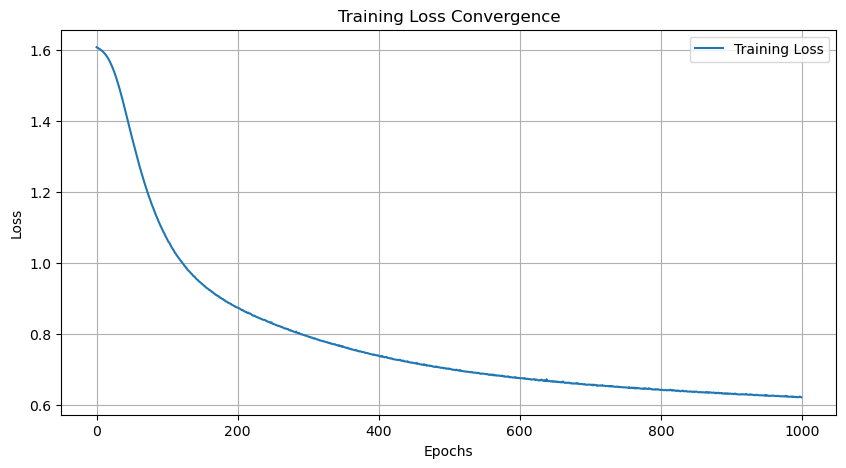

In [ ]:

# Training loop
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in train_dataloader:

        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    loss_history.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}')

# Plotting the convergence of training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.4813


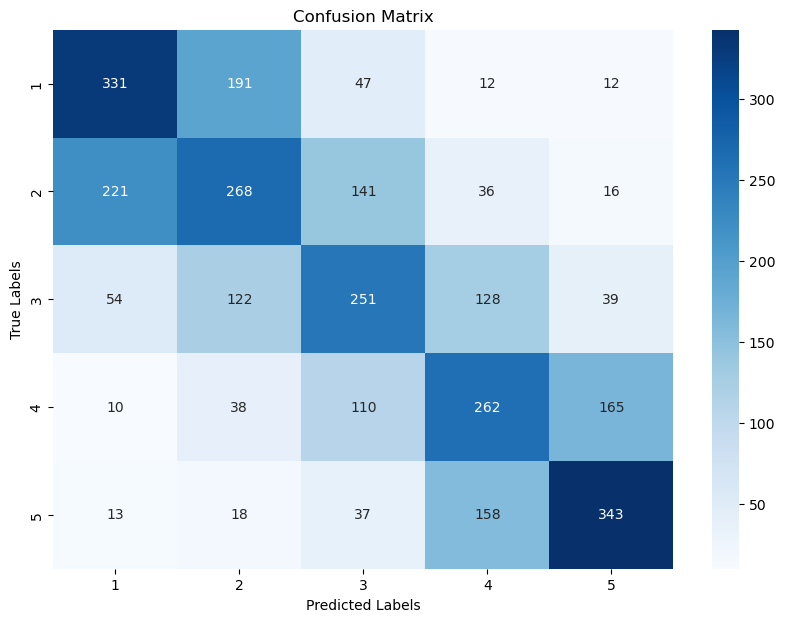

Classification Report:
              precision    recall  f1-score   support

      1 star       0.53      0.56      0.54       593
      2 star       0.42      0.39      0.41       682
      3 star       0.43      0.42      0.43       594
      4 star       0.44      0.45      0.44       585
      5 star       0.60      0.60      0.60       569

    accuracy                           0.48      3023
   macro avg       0.48      0.48      0.48      3023
weighted avg       0.48      0.48      0.48      3023



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:

            if inputs.dim() == 2:
                inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    report = classification_report(true_labels, predictions, target_names=[f'{i} star' for i in range(1, 6)])
    print("Classification Report:")
    print(report)

    return accuracy

# Evaluate the model on the test dataloader
accuracy = evaluate_model(model, test_dataloader)

HYPERPARAMETER TUNING

Accuracy: 0.3245


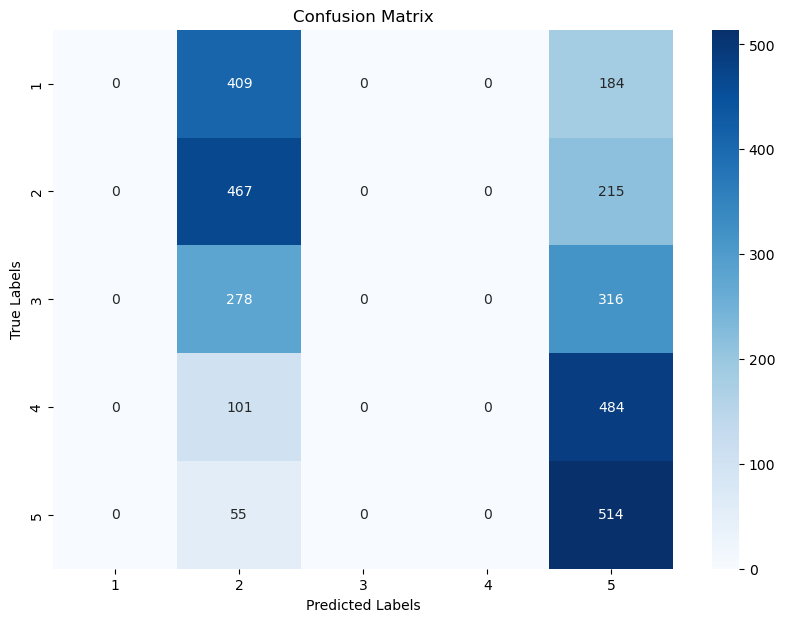

Classification Report:
              precision    recall  f1-score   support

      1 star       0.00      0.00      0.00       593
      2 star       0.36      0.68      0.47       682
      3 star       0.00      0.00      0.00       594
      4 star       0.00      0.00      0.00       585
      5 star       0.30      0.90      0.45       569

    accuracy                           0.32      3023
   macro avg       0.13      0.32      0.18      3023
weighted avg       0.14      0.32      0.19      3023



/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3682


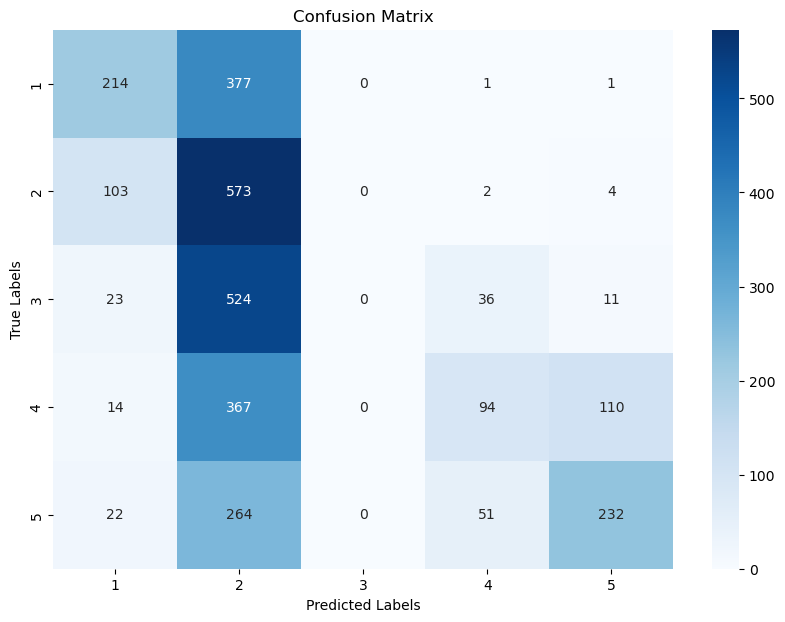

Classification Report:
              precision    recall  f1-score   support

      1 star       0.57      0.36      0.44       593
      2 star       0.27      0.84      0.41       682
      3 star       0.00      0.00      0.00       594
      4 star       0.51      0.16      0.24       585
      5 star       0.65      0.41      0.50       569

    accuracy                           0.37      3023
   macro avg       0.40      0.35      0.32      3023
weighted avg       0.39      0.37      0.32      3023



/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5230


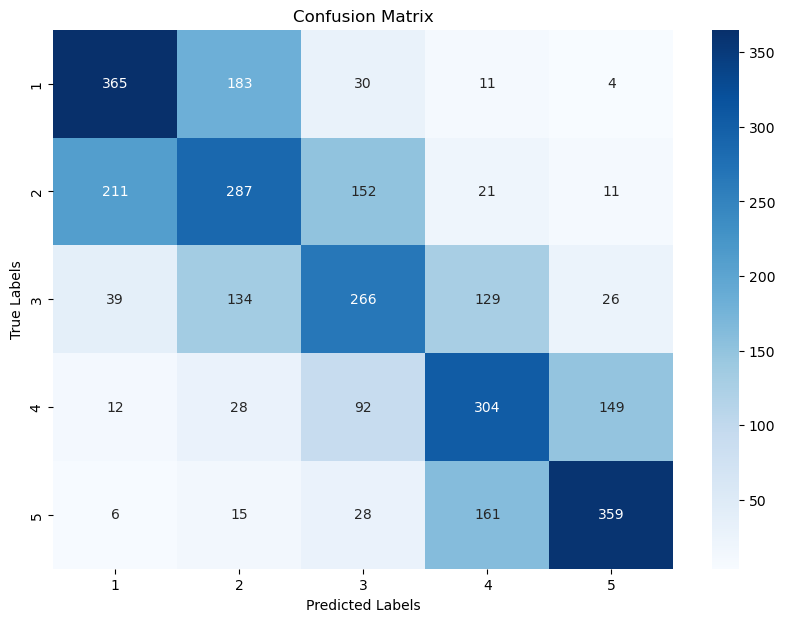

Classification Report:
              precision    recall  f1-score   support

      1 star       0.58      0.62      0.60       593
      2 star       0.44      0.42      0.43       682
      3 star       0.47      0.45      0.46       594
      4 star       0.49      0.52      0.50       585
      5 star       0.65      0.63      0.64       569

    accuracy                           0.52      3023
   macro avg       0.53      0.53      0.53      3023
weighted avg       0.52      0.52      0.52      3023

Accuracy: 0.5243


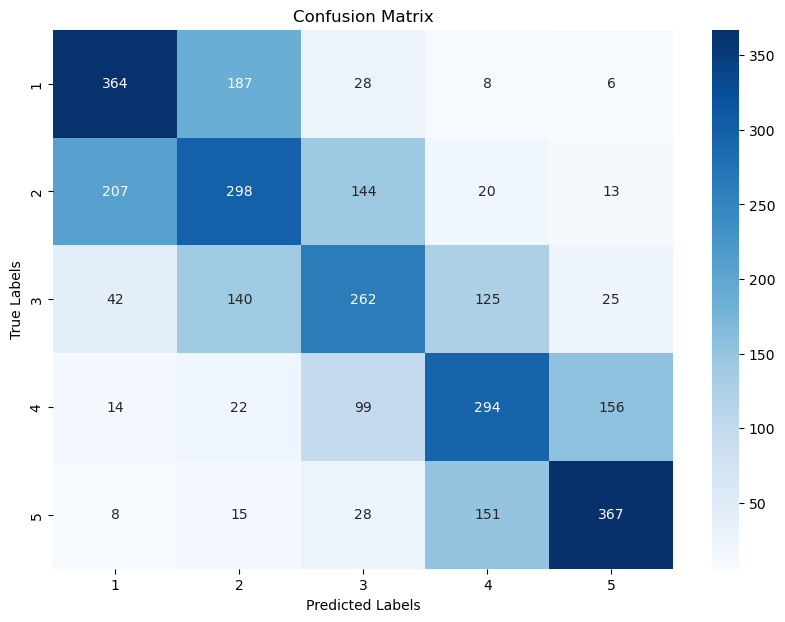

Classification Report:
              precision    recall  f1-score   support

      1 star       0.57      0.61      0.59       593
      2 star       0.45      0.44      0.44       682
      3 star       0.47      0.44      0.45       594
      4 star       0.49      0.50      0.50       585
      5 star       0.65      0.64      0.65       569

    accuracy                           0.52      3023
   macro avg       0.53      0.53      0.53      3023
weighted avg       0.52      0.52      0.52      3023

Accuracy: 0.5200


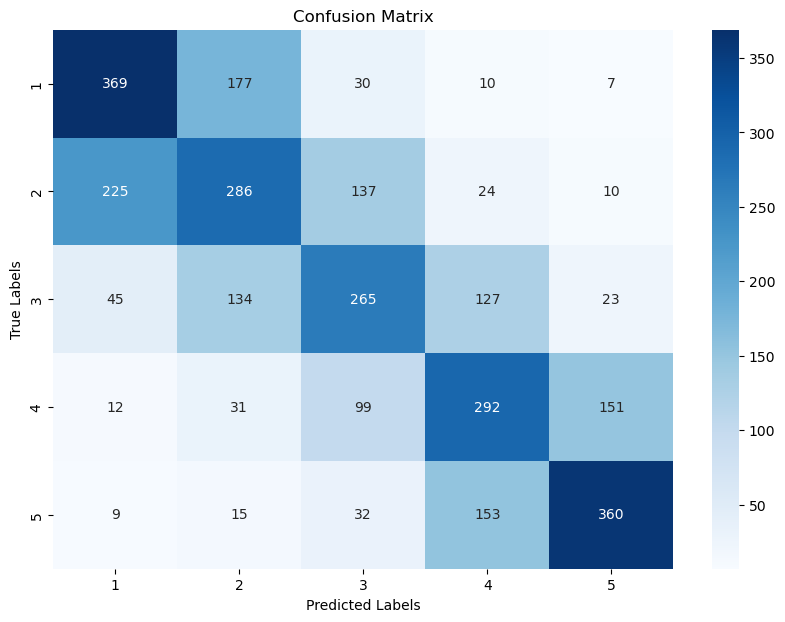

Classification Report:
              precision    recall  f1-score   support

      1 star       0.56      0.62      0.59       593
      2 star       0.44      0.42      0.43       682
      3 star       0.47      0.45      0.46       594
      4 star       0.48      0.50      0.49       585
      5 star       0.65      0.63      0.64       569

    accuracy                           0.52      3023
   macro avg       0.52      0.52      0.52      3023
weighted avg       0.52      0.52      0.52      3023

Accuracy: 0.2041


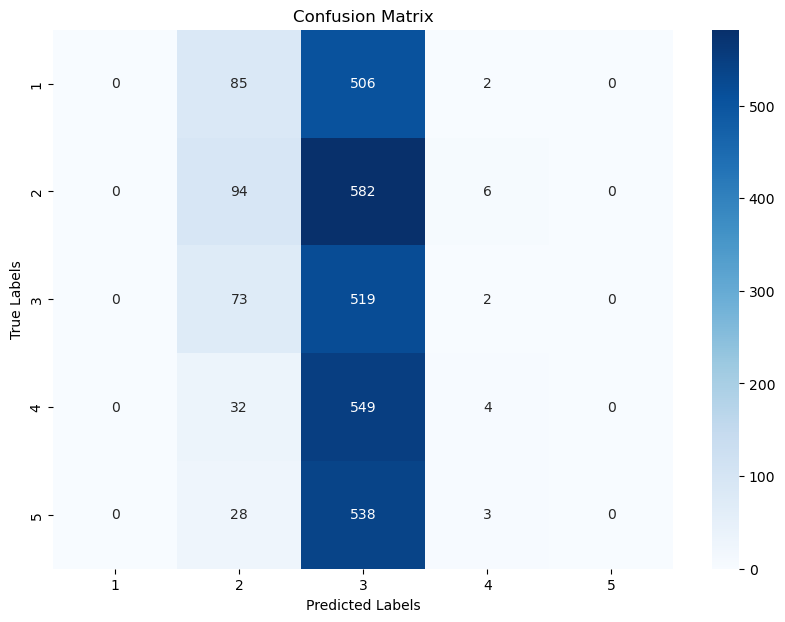

Classification Report:
              precision    recall  f1-score   support

      1 star       0.00      0.00      0.00       593
      2 star       0.30      0.14      0.19       682
      3 star       0.19      0.87      0.32       594
      4 star       0.24      0.01      0.01       585
      5 star       0.00      0.00      0.00       569

    accuracy                           0.20      3023
   macro avg       0.15      0.20      0.10      3023
weighted avg       0.15      0.20      0.11      3023



/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4188


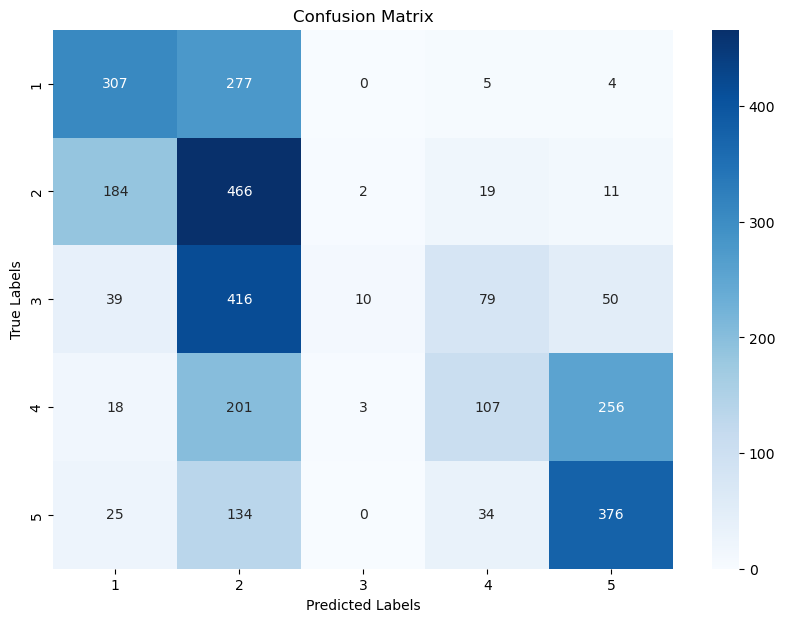

Classification Report:
              precision    recall  f1-score   support

      1 star       0.54      0.52      0.53       593
      2 star       0.31      0.68      0.43       682
      3 star       0.67      0.02      0.03       594
      4 star       0.44      0.18      0.26       585
      5 star       0.54      0.66      0.59       569

    accuracy                           0.42      3023
   macro avg       0.50      0.41      0.37      3023
weighted avg       0.49      0.42      0.37      3023

Accuracy: 0.2034


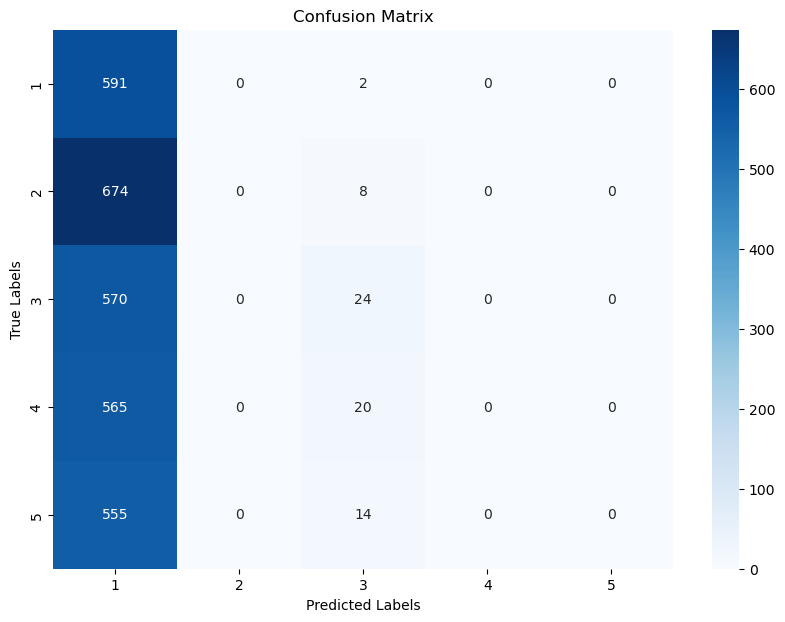

Classification Report:
              precision    recall  f1-score   support

      1 star       0.20      1.00      0.33       593
      2 star       0.00      0.00      0.00       682
      3 star       0.35      0.04      0.07       594
      4 star       0.00      0.00      0.00       585
      5 star       0.00      0.00      0.00       569

    accuracy                           0.20      3023
   macro avg       0.11      0.21      0.08      3023
weighted avg       0.11      0.20      0.08      3023



/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saum/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5260


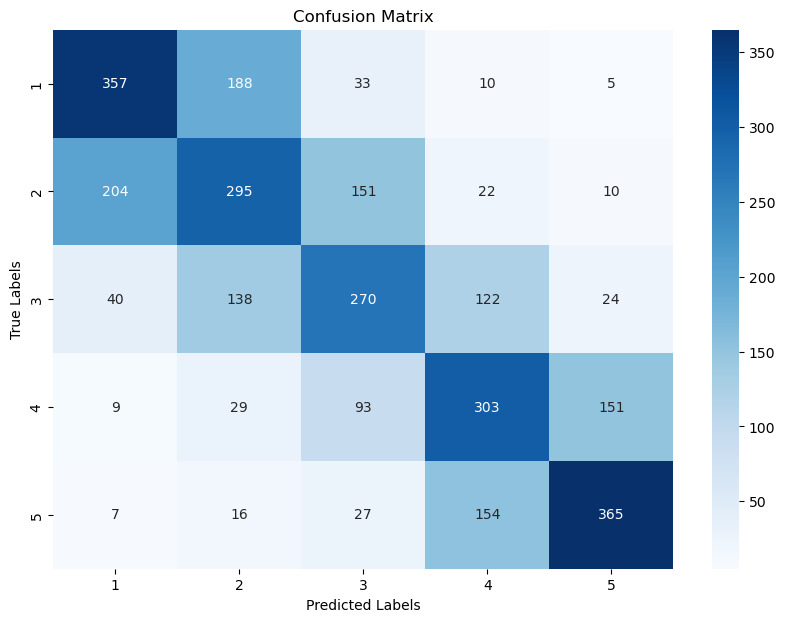

Classification Report:
              precision    recall  f1-score   support

      1 star       0.58      0.60      0.59       593
      2 star       0.44      0.43      0.44       682
      3 star       0.47      0.45      0.46       594
      4 star       0.50      0.52      0.51       585
      5 star       0.66      0.64      0.65       569

    accuracy                           0.53      3023
   macro avg       0.53      0.53      0.53      3023
weighted avg       0.53      0.53      0.53      3023

Accuracy: 0.5230


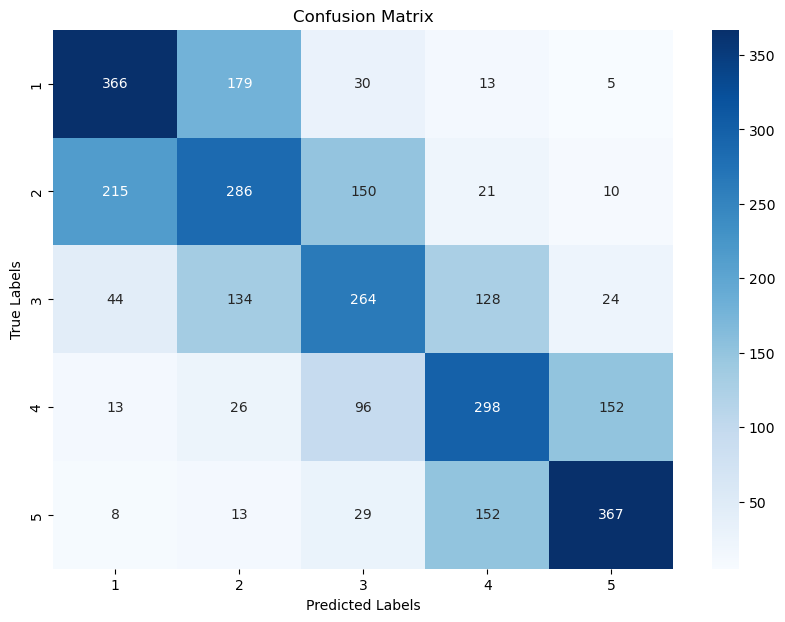

Classification Report:
              precision    recall  f1-score   support

      1 star       0.57      0.62      0.59       593
      2 star       0.45      0.42      0.43       682
      3 star       0.46      0.44      0.45       594
      4 star       0.49      0.51      0.50       585
      5 star       0.66      0.64      0.65       569

    accuracy                           0.52      3023
   macro avg       0.52      0.53      0.53      3023
weighted avg       0.52      0.52      0.52      3023

Best model accuracy: 0.5259675818723123


In [ ]:
from sklearn.model_selection import ParameterSampler

param_grid = {
    'hidden_dim': [64, 128, 256],
    'learning_rate': [0.0001, 0.00001, 0.000001],
    'batch_size': [32, 64, 128]
}

param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

best_model = None
best_accuracy = 0

for params in param_list:
    model = LSTMModel(input_dim, params['hidden_dim'], output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)


    for epoch in range(50):
        model.train()
        for inputs, labels in train_dataloader:
            inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

    accuracy = evaluate_model(model, test_dataloader)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"Best model accuracy: {best_accuracy}")
